# Module Two Final Project

*By: Jonathan Ericksen*

*For: Northwind*

### Background:

>Northwind is a small company looking to gain critical insights provided by the data housed within their data warehouse. Northwind is looking to make strategic moves based on insights gleaned from the data. As a small company, their reserouces are limited, thus, Northwind has contracted with JE Consulting to analyze the data and perform a number of statistical tests answering key questions posed by management. 

### Objective:

>The objective for JE Consulting is to extract the necessary data from their SQL based database and perform four statistical tests that determine with confidence whether or not previous, non-data driven assumptions about their operations, are indeed correct. 

>The results of these tests will be used by the management team to assess future strategies for improving revenue growth and improving overall operational efficiency. These tests will direct  company resources towards yielding the highest return on companies capital. The conclusions of these tests, and the implications for Northwind, will be summarized in the 'Conclusions' portion of the notebook. 

>Last, JE Consulting was asked to provide recommendations for further work as they continue to seek areas for further statistical analysis. JE Consulting will provide these recommendations in the 'Future Work' portion of the notebook. 


### Table of Contents: <a id='top'></a>

>#### [Libraries & Packages](#libraries&packages)
>#### [Exploratory Data Analysis:](#exploratorydataanalysis)
>>- What data are available to us?
- What do they sell?
- How many employees do they have?
- Where do they operate?
- What is their annual revenue?
- Where do they ship?
>#### [Hypothesis Testing:](#hypothesistesting)
>>- **Hypothesis Test #1:**
    - Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
- **Hypothesis Test #2:**
    - Is the average order size in North America larger than international order sizes?
- **Hypothesis Test #3:**
    - Does order size vary in a statistically significant way between Northwind employees?
- **Hypothesis Test #4:**
    - Does the average revenue per order differ in 2014 from 2012 & 2013??
>#### [Conclusions](#conclusion)
>#### [Future Work](#futurework)

------------------------------------------------------------------------------------------------------------------

### Libraries & Packages <a id='libraries&packages'></a>

We begin by importing the necessary libraries for use in extracting data from the Northwind Database, EDA & Hypothesis Testing:

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

from IPython.display import Image

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import sqlite3

import scipy.stats as scs
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Exploratory Data Analysis <a id='exploratorydataanalysis'></a>

[Back to top](#top)

To begin, we'll connect SQLAlchemy to our database by creating an engine, binding it to a new session with a sessionmaker, and then creating a new Session object:

In [2]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

Further, we'll connect to our database using SQLite3 as a another SQL tool with different functionality for querying our database: 

In [3]:
conn = engine.connect()
connect = sqlite3.connect('Northwind_small.sqlite')
cursor = connect.cursor()

2019-06-16 12:49:53,468 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-16 12:49:53,469 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:49:53,476 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-16 12:49:53,476 INFO sqlalchemy.engine.base.Engine ()


### *What data are available to us?*

Let's retrieve and inspect the table names within the database to get a better sense of the data available to us:

In [4]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

2019-06-16 12:49:56,836 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-06-16 12:49:56,837 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

We've asked the database engineers at Northwind to provide a copy of Entity Relational Diagram (ERD) for visual reference during our EDA process. An image of the diagram is provided below:

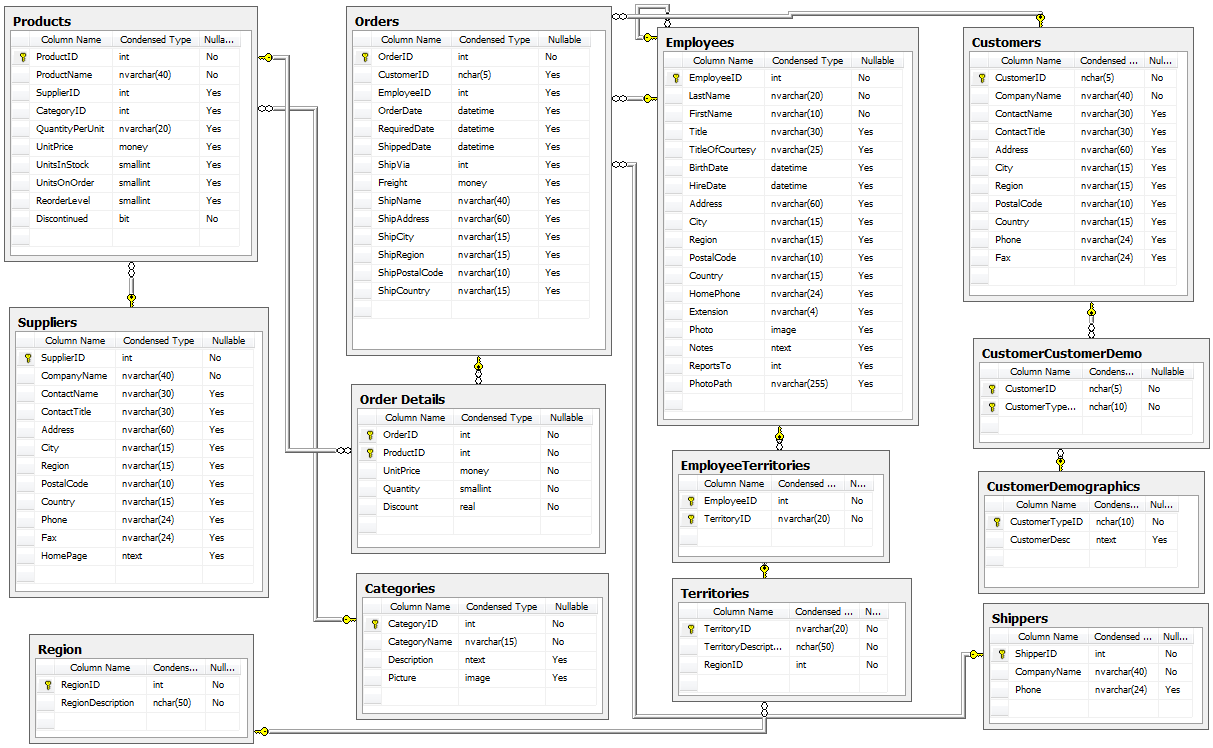

In [5]:
Image(filename = 'Northwind_ERD.png', width=950, height=800)

We'll now build a function that takes in a table name within the database and returns the columns and data types stored within each column for use throughout the EDA process:

In [6]:
def get_columns_info(table_name):
    cols_list = inspector.get_columns(table_name)
    
    print("Table Name: {}".format(table_name))
    print()
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

Further, we'll convert all the tables within the database to their own separate pandas dataframe while storing them in a dictionary for ease of reference during the EDA and hypothesis testing phases:

In [7]:
sql_connector = ['SELECT * FROM [Order]' if name == 'Order' else 'SELECT * FROM ' + name for name in table_names]

dataframes = {}

for table, sql_connector in zip(table_names, sql_connector):
    dataframes[table] = pd.read_sql_query(sql_connector, conn)

2019-06-16 12:50:23,197 INFO sqlalchemy.engine.base.Engine SELECT * FROM Category
2019-06-16 12:50:23,198 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,209 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-06-16 12:50:23,210 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,215 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerCustomerDemo
2019-06-16 12:50:23,216 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,219 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerDemographic
2019-06-16 12:50:23,220 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,224 INFO sqlalchemy.engine.base.Engine SELECT * FROM Employee
2019-06-16 12:50:23,225 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,232 INFO sqlalchemy.engine.base.Engine SELECT * FROM EmployeeTerritory
2019-06-16 12:50:23,232 INFO sqlalchemy.engine.base.Engine ()
2019-06-16 12:50:23,236 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-06-16 12:50:23,237

As a final step in better understanding the data, we're going to download a few of the tables to a csv files for further visual exploration in a separate software application: Tableau. A few of the graphics created in Tableau will appear throughout this project. We'll create the individual dataframes and then save them to a csv files:

In [8]:
c = dataframes['Customer']
e = dataframes['Employee']
od = dataframes['OrderDetail']
o = dataframes['Order']
s = dataframes['Supplier']

In [9]:
c.to_csv('Customers.csv')
e.to_csv('Employee.csv')
od.to_csv('OrderDetail.csv')
o.to_csv('Order.csv')
s.to_csv('Suppliers.csv')

### *What do they sell?*

To answer our first question, we'll use our 'get_columns_info' function to inspect a few of the tables as well as review the dataframe head of these tables to discover what the Northwind sells:

In [10]:
get_columns_info('Product')

2019-06-16 12:51:33,761 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-06-16 12:51:33,762 INFO sqlalchemy.engine.base.Engine ()
Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER


Let's use our dataframes dictionary to retrieve the data within the 'product' table:

In [11]:
products_df = dataframes['Product']
products_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Next we'll take a look at the 'category' table as that houses additional information regarding the products sold:

In [12]:
get_columns_info('category')

2019-06-16 12:51:42,582 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("category")
2019-06-16 12:51:42,583 INFO sqlalchemy.engine.base.Engine ()
Table Name: category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)


In [13]:
categories_df = dataframes['Product']
categories_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Now we'll join the 'product' and 'category' table to get a holistic snapshot of all products sold thus answering the question: *What do they sell?*

In [14]:
product_descriptions_df = pd.read_sql_query(
    '''
    SELECT
    
    p.productname,
    c.categoryname, 
    c.description

    FROM product AS p
    LEFT JOIN category AS c
    ON p.categoryid = c.id

    ''', engine)

product_descriptions_df.head(11)

2019-06-16 12:51:52,570 INFO sqlalchemy.engine.base.Engine 
    SELECT
    
    p.productname,
    c.categoryname, 
    c.description

    FROM product AS p
    LEFT JOIN category AS c
    ON p.categoryid = c.id

    
2019-06-16 12:51:52,571 INFO sqlalchemy.engine.base.Engine ()


,ProductName,CategoryName,Description
0,Chai,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Chang,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,Aniseed Syrup,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
3,Chef Anton's Cajun Seasoning,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
4,Chef Anton's Gumbo Mix,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
5,Grandma's Boysenberry Spread,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
6,Uncle Bob's Organic Dried Pears,Produce,Dried fruit and bean curd
7,Northwoods Cranberry Sauce,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
8,Mishi Kobe Niku,Meat/Poultry,Prepared meats
9,Ikura,Seafood,Seaweed and fish


How many different products do they sell? 

In [15]:
print('Northwind sells {} different products.'.format(len(product_descriptions_df)))

Northwind sells 77 different products.


### *How many employees does Northwind have?*

Let's get a better understanding of the employee table by calling the employee table from our dataframes dictionary: 

In [16]:
employees_df = dataframes['Employee']
employees_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


Next we'll run a query that calls the firstname, lastname, and title of each employee. We'll use pandas to save the data in a dataframe variable:

In [17]:
employee_df = pd.read_sql_query(
    '''SELECT 
    
    lastname,
    firstname,
    title
    
    FROM employee''', engine)
    
employee_df.head(20)

2019-06-16 12:52:11,658 INFO sqlalchemy.engine.base.Engine SELECT 
    
    lastname,
    firstname,
    title
    
    FROM employee
2019-06-16 12:52:11,659 INFO sqlalchemy.engine.base.Engine ()


,LastName,FirstName,Title
0,Davolio,Nancy,Sales Representative
1,Fuller,Andrew,"Vice President, Sales"
2,Leverling,Janet,Sales Representative
3,Peacock,Margaret,Sales Representative
4,Buchanan,Steven,Sales Manager
5,Suyama,Michael,Sales Representative
6,King,Robert,Sales Representative
7,Callahan,Laura,Inside Sales Coordinator
8,Dodsworth,Anne,Sales Representative


Now that we have the data from the employee table, we can answer how many employees work at Northwind:

In [18]:
print('Northwind has {} employees.'.format(len(employee_df)))

Northwind has 9 employees.


### *Where do they operate?*

Let's take a look at the 'Employees' table again to see the cities from which the employees live:

In [19]:
employee_df = pd.read_sql_query(
    '''SELECT 
    
    lastname,
    firstname,
    title,
    city,
    region
    
    FROM employee''', engine)
    
employee_df.head(20)

2019-06-16 12:52:28,493 INFO sqlalchemy.engine.base.Engine SELECT 
    
    lastname,
    firstname,
    title,
    city,
    region
    
    FROM employee
2019-06-16 12:52:28,494 INFO sqlalchemy.engine.base.Engine ()


,LastName,FirstName,Title,City,Region
0,Davolio,Nancy,Sales Representative,Seattle,North America
1,Fuller,Andrew,"Vice President, Sales",Tacoma,North America
2,Leverling,Janet,Sales Representative,Kirkland,North America
3,Peacock,Margaret,Sales Representative,Redmond,North America
4,Buchanan,Steven,Sales Manager,London,British Isles
5,Suyama,Michael,Sales Representative,London,British Isles
6,King,Robert,Sales Representative,London,British Isles
7,Callahan,Laura,Inside Sales Coordinator,Seattle,North America
8,Dodsworth,Anne,Sales Representative,London,British Isles


It looks like Northwind located in two regions while operating from 5 separate cities.

### *What is their annual revenue?*

For this question, we'll join the 'order', 'product' and 'order details' tables to get some revenue insights for one fiscal year. We'll start by reviewing the tables separately and then joining them to aggregate the price figures by product: 

In [20]:
dataframes['Order'].head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [21]:
dataframes['OrderDetail'].head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [22]:
dataframes['Product'].head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Let's build out table with the needed data to calculate annual revenue:

In [23]:
rev_date = pd.read_sql_query(
    '''
    SELECT 
    
    p.unitprice,
    od.quantity,
    od.discount,
    o.orderdate
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN product AS p
    ON p.id = od.productid
    
    ''', engine)

rev_date.head()

2019-06-16 12:53:16,195 INFO sqlalchemy.engine.base.Engine 
    SELECT 
    
    p.unitprice,
    od.quantity,
    od.discount,
    o.orderdate
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN product AS p
    ON p.id = od.productid
    
    
2019-06-16 12:53:16,195 INFO sqlalchemy.engine.base.Engine ()


,UnitPrice,Quantity,Discount,OrderDate
0,21.00,12,0.0,2012-07-04
1,14.00,10,0.0,2012-07-04
2,34.80,5,0.0,2012-07-04
3,23.25,9,0.0,2012-07-05
4,53.00,40,0.0,2012-07-05


We'll need to do some conditioning on our new dataframe: isolate the date column by year, convert the new year column to an integer datatype, drop the original 'orderdate' column, calculate the price per unit sold:

In [24]:
yr = rev_date['OrderDate'].str.split('-', n = 1, expand = True)
rev_date['Year'] = yr[0]

rev_date.drop(columns=['OrderDate'], inplace = True)

rev_date['Year'] = rev_date['Year'].astype(int)

rev_date['Revenue'] = rev_date['UnitPrice'] * (1-rev_date['Discount']) * rev_date['Quantity']

In [25]:
rev_date.head()

,UnitPrice,Quantity,Discount,Year,Revenue
0,21.00,12,0.0,2012,252.00
1,14.00,10,0.0,2012,140.00
2,34.80,5,0.0,2012,174.00
3,23.25,9,0.0,2012,209.25
4,53.00,40,0.0,2012,2120.00


Now that we've calculated revenue per order, we can drop 'UnitPrice','Quantity'and 'Discount' columns:

In [26]:
rev_by_yr = rev_date.drop(columns = ['UnitPrice','Quantity','Discount'], axis = 1)
rev_by_yr.head()

,Year,Revenue
0,2012,252.00
1,2012,140.00
2,2012,174.00
3,2012,209.25
4,2012,2120.00


Finally, we'll group the data by year and sum the revenue figures to get our annual revenues:

In [27]:
rev_year = rev_by_yr.groupby(by = ['Year']).sum().round(2)
rev_year.head()

,Revenue
Year,
2012,260265.37
2013,652813.73
2014,440623.87


### *Where do they ship?*

Below, we've built a visual using the popular visualization platform Tableau. The graphic visualizes the countries to which Northwind ships it's products. These data represent total shipments from 2012 - 2014, with the size of each bubble representing the relative number of shipments. This answers our question: *Where do they ship?*

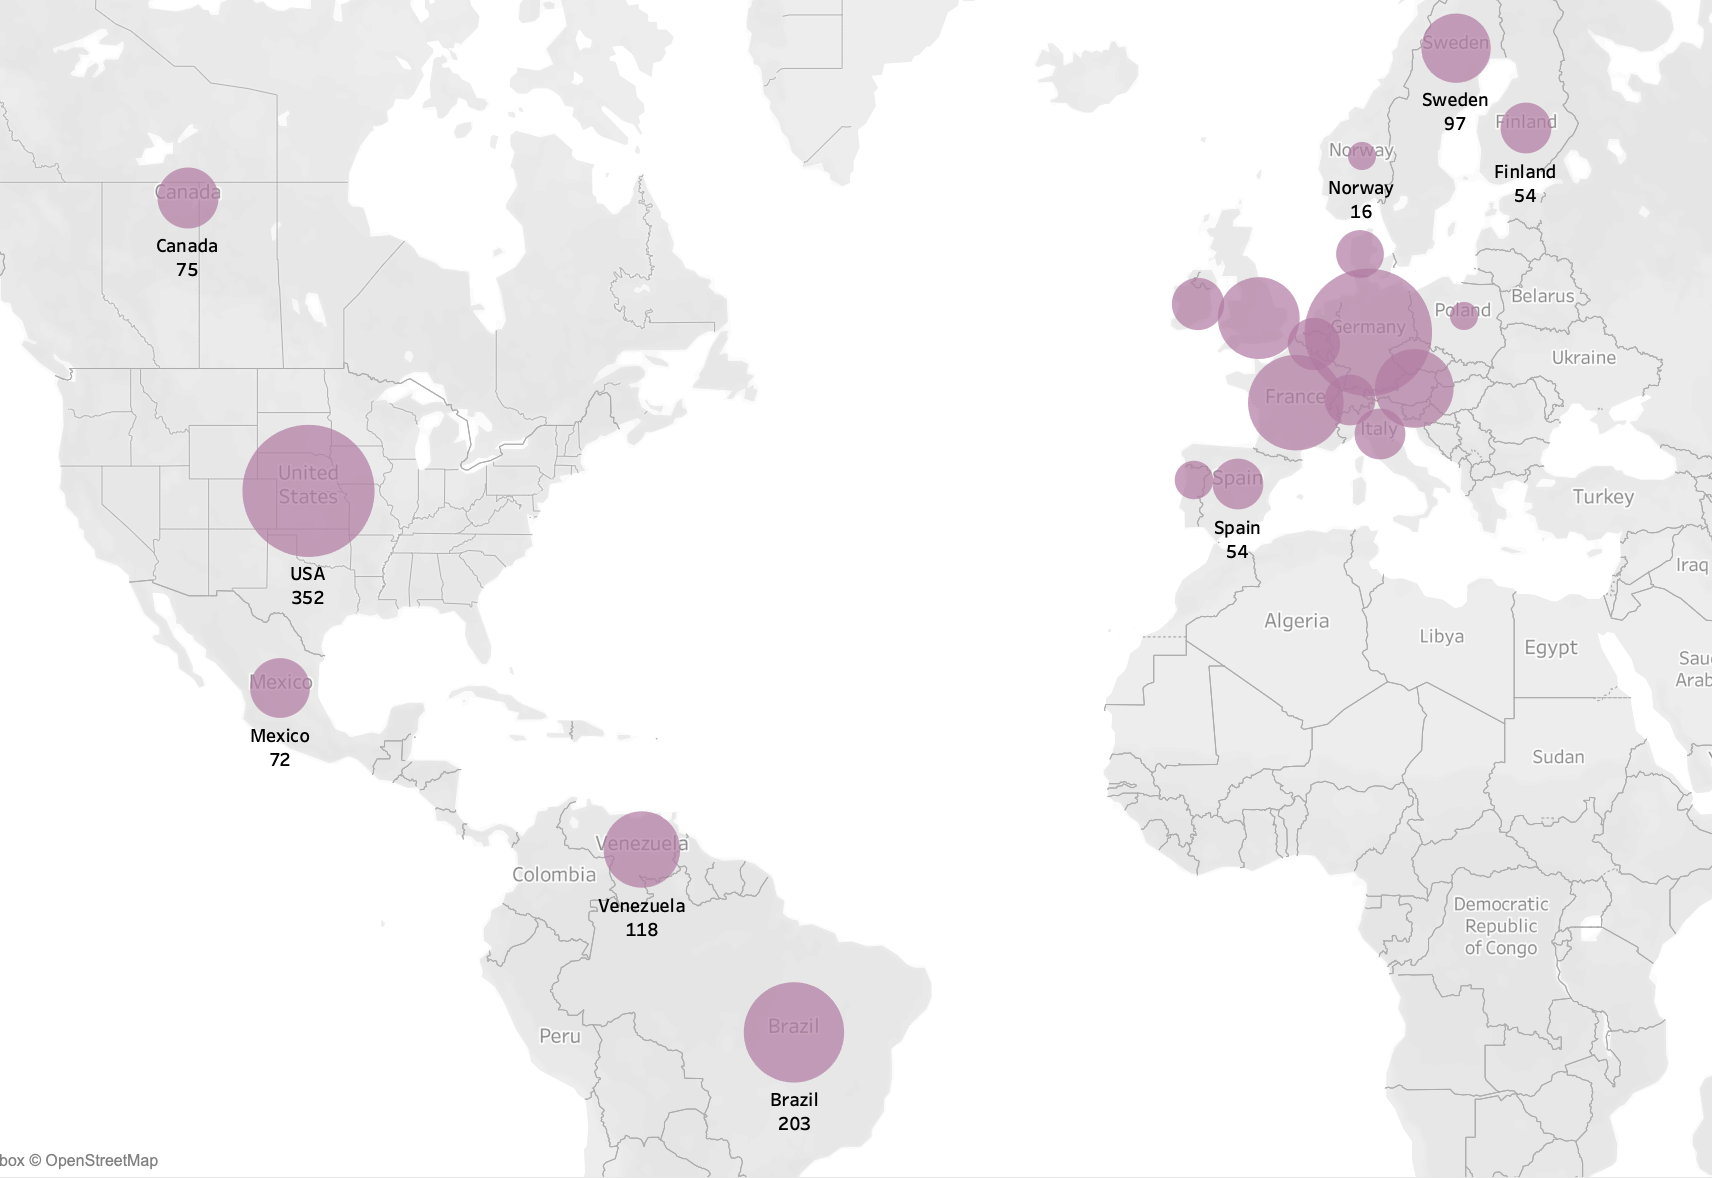

In [28]:
Image(filename = 'Map.png', width=900, height=600)

------------------------------------------------------------------------------------------------------------------

## Hypothesis Testing <a id='hypothesistesting'></a>

[Back to top](#top) 

### *Test One*

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**

This question has two parts, which are outlined below:  

> Part one can be reconfigured to the following Null and Alternative Hypothesis:
> - Ho: $\mu_1 = \mu_2$ - Control group = Treatment group, i.e., the mean number of products sold with and without a discount is equal.
> - Ha: $\mu_1 \neq \mu_2$ - Control group $\neq$ Treatment group, i.e., the mean number of products sold with a discount is statistically larger, or smaller, than the mean number of products sold with a discount.

> Part two of the above question can be reconfigured as the following:
> - Ho: $\mu_1 = \mu_2 = ... \mu_k$ - Control group = Treatment group at all levels of discount, i.e, the number of products sold with differing levels of discounts do not vary from products sold without a discount.
> - Ha: $\mu_1 \neq \mu_2  \neq... \mu_k$ - Control group $\neq$ Treatment group at all levels of discount, i.e, the number of products sold with differing levels of discounts do vary from products sold without a discount.

#### *Part One - Two Sample T-Test:*

We'll begin part one by splitting the test variable into two separate dataframes: products sold with discounts (treatment group) and products sold without discounts (control group).

Let's take a look at the 'OrderDetail' table again:

In [29]:
order_details = dataframes['OrderDetail']
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


We'll run a query that creates a dataframe of all orders with no discount to create our control variable: 

In [30]:
orders_no_discount = pd.read_sql_query(
    '''
    SELECT quantity
    FROM orderdetail
    WHERE discount = 0
    ''', engine)

orders_no_discount.head()

2019-06-16 12:54:46,255 INFO sqlalchemy.engine.base.Engine 
    SELECT quantity
    FROM orderdetail
    WHERE discount = 0
    
2019-06-16 12:54:46,256 INFO sqlalchemy.engine.base.Engine ()


,Quantity
0,12
1,10
2,5
3,9
4,40


We'll do the same thing for orders with a discount (treatment group):

In [31]:
orders_w_discount = pd.read_sql_query(
    '''
    SELECT quantity
    FROM orderdetail
    WHERE discount > 0
    ''', engine)

orders_w_discount.head()

2019-06-16 12:54:49,480 INFO sqlalchemy.engine.base.Engine 
    SELECT quantity
    FROM orderdetail
    WHERE discount > 0
    
2019-06-16 12:54:49,481 INFO sqlalchemy.engine.base.Engine ()


,Quantity
0,35
1,15
2,6
3,15
4,40


Now let's get some basic statistics on products sold with and without a discount: 

In [64]:
print('-'*100)
print('Number of orders WITHOUT disocunts: {}'.format(len(orders_no_discount)))
print('Number of orders sold WITH discounts: {}'.format(len(orders_w_discount))) 
#print()
print('-'*100)
#print()
print('Average order size WITHOUT discounts: {}'.format(orders_no_discount['Quantity'].mean()))
print('Average order size WITH discounts: {}'.format(orders_w_discount['Quantity'].mean()))
print('-'*100)
print('The mean delta: ', abs((orders_no_discount['Quantity'].mean()) - (orders_w_discount['Quantity'].mean())))

----------------------------------------------------------------------------------------------------
Number of orders WITHOUT disocunts: 1317
Number of orders sold WITH discounts: 838
----------------------------------------------------------------------------------------------------
Average order size WITHOUT discounts: 21.715261958997722
Average order size WITH discounts: 27.10978520286396
----------------------------------------------------------------------------------------------------
The mean delta:  5.394523243866239


Next, we'll plot the PDF for products sold with and without discounts to asses normality within the distributions:

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


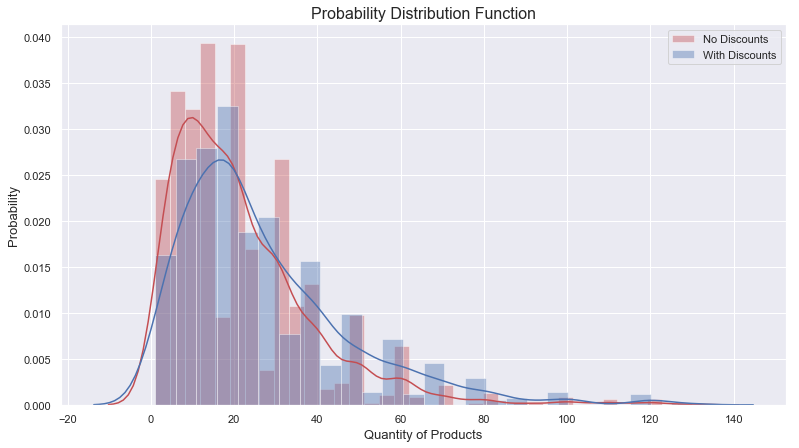

In [65]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(13,7)})

sns.distplot(orders_no_discount, label = 'No Discounts', color = 'r')
sns.distplot(orders_w_discount, label = 'With Discounts') 

plt.title('Probability Distribution Function', size = 16)
plt.ylabel('Probability', size = 13)
plt.xlabel('Quantity of Products', size = 13)

plt.legend()
plt.show()

We'll run a shapiro test on our variables to test for normality within the distributions to satisfy our assumption of normal distributions when running a t-test: 

In [66]:
no_disc_norm = stats.shapiro(orders_no_discount)
w_disc_norm = stats.shapiro(orders_w_discount)

print('The p_value for orders with no discounts is:', no_disc_norm[1])
print('The p_value for order with a discount is:', w_disc_norm[1])

The p_value for orders with no discounts is: 3.803856556577728e-34
The p_value for order with a discount is: 6.88120409395894e-26


Given our p_values from the shapiro test are inadequate, we'll need to take the mean from a number of samples drawn from the control and treatment groups to establish normal distributions for running our statistical test:

In [70]:
no_discount_samps = [orders_no_discount['Quantity'].sample(n=30, replace = True).mean() for i in range (100)]
w_discount_samps = [orders_w_discount['Quantity'].sample(n=30, replace = True).mean() for i in range (100)]

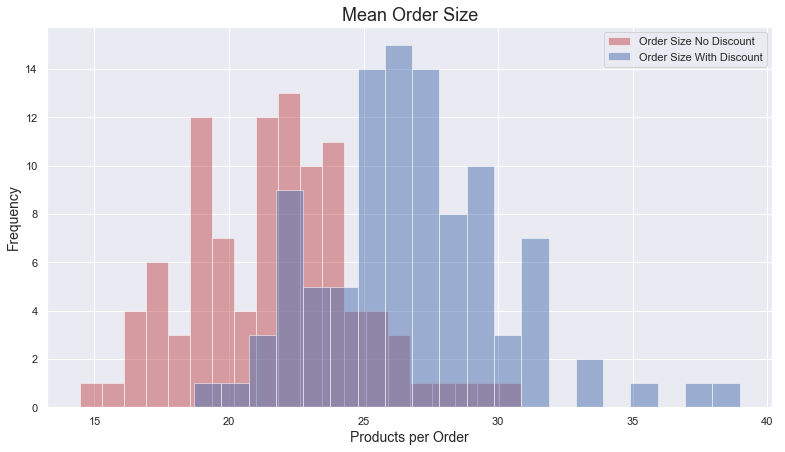

In [71]:
plt.hist(no_discount_samps, label = 'Order Size No Discount', alpha = .5, color = 'r', bins=20)
plt.hist(w_discount_samps, label = 'Order Size With Discount', alpha = .5, bins=20)

plt.title('Mean Order Size', size = 18)
plt.xlabel('Products per Order', size = 14)
plt.ylabel('Frequency', size = 14)

plt.legend()
plt.show()

We'll re-run the shapiro test again to assess normality of our sampling populations:

In [73]:
no_disc_norm = stats.shapiro(no_discount_samps)
w_disc_norm = stats.shapiro(w_discount_samps)

print('The p_value for orders with no discounts is:', no_disc_norm[1])
print('The p_value for order with a discount is:', w_disc_norm[1])

The p_value for orders with no discounts is: 0.3082117736339569
The p_value for order with a discount is: 0.3462585508823395


Now that we've acquired normality via the sampling distributions, let's run a two sample t-test to extract our t-statistic and p-value:

In [74]:
tstat, pval = scs.ttest_ind(w_discount_samps, no_discount_samps)

print('T-Value = ', tstat)
print('P-Value = ', pval)

T-Value =  11.199520190145822
P-Value =  7.195970232740309e-23


Let's declare our Cohen's D function to assess the effect size between the distributions: 

In [75]:
def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    pooled_var = (n1* var1 + n2* var2)/ (n1 + n2)
    
    cohen_d = diff/np.sqrt(pooled_var)
    
    return print("The cohen's statistic is:", cohen_d)

We'll run our Cohen's D function to assess effect size:

In [77]:
w_discount_samps = pd.DataFrame(w_discount_samps)
no_discount_samps = pd.DataFrame(no_discount_samps)

In [78]:
cohens_d(w_discount_samps, no_discount_samps)

The cohen's statistic is: 0    1.583851
dtype: float64


#### *Part One Conclusion*: 

With a p_value less than .05, we reject the null hypothesis and accept the alternative hypothesis. Which is to say, the application of discounts does have a statistically significant effect on the nuumber of products ordered. With a Cohen's D value of 1.6, we conclude the effect of discounts on order size is quite large.  

#### *Part Two - Tukey Test:*

To answer the second part of the question, we'll begin by splitting out the orders by differing discount levels. Let's write a query that sums the order and quantity amounts sold per discount level:

In [79]:
discount_summary = pd.read_sql_query(
    '''SELECT 
    SUM(quantity),
    COUNT(orderid),
    discount 
    FROM orderdetail 
    GROUP BY discount
    ''', engine)

discount_summary

2019-06-14 20:45:07,424 INFO sqlalchemy.engine.base.Engine SELECT 
    SUM(quantity),
    COUNT(orderid),
    discount 
    FROM orderdetail 
    GROUP BY discount
    
2019-06-14 20:45:07,426 INFO sqlalchemy.engine.base.Engine ()


,SUM(quantity),COUNT(orderid),Discount
0,28599,1317,0.00
1,2,1,0.01
2,4,2,0.02
3,5,3,0.03
4,1,1,0.04
5,5182,185,0.05
6,2,1,0.06
7,4366,173,0.10
8,4456,157,0.15
9,4351,161,0.20


Based on the above query, write a new query that remove the discount levels with limited orders leaving orders at the 0%, 5%, 10%, 15%, 20%, and 25% discount levels:

In [80]:
discounts_grouped = pd.read_sql_query(
    '''SELECT 
    quantity,
    discount 
    FROM orderdetail 
    WHERE discount = 0 OR discount = .05 OR discount = .10 OR discount = .15 OR discount = .20 OR discount = .25
    ''', engine)

discounts_grouped.head()

2019-06-14 20:47:08,736 INFO sqlalchemy.engine.base.Engine SELECT 
    quantity,
    discount 
    FROM orderdetail 
    WHERE discount = 0 OR discount = .05 OR discount = .10 OR discount = .15 OR discount = .20 OR discount = .25
    
2019-06-14 20:47:08,737 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


Let's now run our Tukey test to assess at what levels of discount (treatment group) there is a statistically significant difference to orders with no discount (control group):  

In [81]:
results = sm.stats.multicomp.pairwise_tukeyhsd(discounts_grouped['Quantity'], discounts_grouped['Discount'], 0.05)
print(results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


#### *Part Two Conclusion:* 
With an alpha of 0.05, we accept there is a statistically significant differnce in the mean number of products sold at the 5%, 15%, 20% and 25% disount levels from orders with no discount while failing to reject the null hypothesis at the 10% discount level.

### *Test Two - Two Sample T-Test*

**Is the average order size in North America larger than international order sizes?**

> Let's break this question down into it's component parts:
> - Ho: $\mu_1 = \mu_2$: Control group = Treatment group, i.e., the average order size in North America is equivalent to international order sizes. 
> - Ha: $\mu_1 > \mu_2$: Control group > Treatment group, i.e., the average order size in North America is larger than international order sizes. 


To answer this question, we'll need to isolate the quantity of products for all orders in North America and abroad. We'll begin by reviewing the tables containing the necessary data:

In [82]:
dataframes['OrderDetail'].head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [83]:
dataframes['Order'].head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Next, we'll create a dataframe using a new query with necessary data by joining the tables:

In [84]:
regional_orders = pd.read_sql_query(
    '''
    SELECT
    
    od.quantity, 
    o.shipregion
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    
    ''', engine)

regional_orders.head()

2019-06-14 20:50:00,493 INFO sqlalchemy.engine.base.Engine 
    SELECT
    
    od.quantity, 
    o.shipregion
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    
    
2019-06-14 20:50:00,496 INFO sqlalchemy.engine.base.Engine ()


,Quantity,ShipRegion
0,12,Western Europe
1,10,Western Europe
2,5,Western Europe
3,9,Western Europe
4,40,Western Europe


Let's review the different regions within the tables:

In [85]:
regional_orders['ShipRegion'].unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

We'll isolate the control group (North America) from the treatment group (international):

In [86]:
north_america = regional_orders[regional_orders['ShipRegion'] == 'North America']
na_quantity = pd.DataFrame(north_america['Quantity'])
na_quantity.head()

,Quantity
40,12
41,15
42,2
57,60
58,20


In [87]:
international = regional_orders[regional_orders['ShipRegion'] != 'North America']
int_quantity = pd.DataFrame(international['Quantity'])
int_quantity.head()

,Quantity
0,12
1,10
2,5
3,9
4,40


Let's get some basic statistics between our test variables:

In [88]:
print('-'*100)
print('Number of North American orders: {}'.format(len(na_quantity)))
print('Number of international orders: {}'.format(len(int_quantity))) 
#print()
print('-'*100)
#print()
print('Average North American order size: {}'.format(na_quantity['Quantity'].mean()))
print('Average international order size: {}'.format(int_quantity['Quantity'].mean()))
print('-'*100)
print('The mean delta: ', abs((na_quantity['Quantity'].mean()) - (int_quantity['Quantity'].mean())))

----------------------------------------------------------------------------------------------------
Number of North American orders: 427
Number of international orders: 1728
----------------------------------------------------------------------------------------------------
Average North American order size: 26.49648711943794
Average international order size: 23.14988425925926
----------------------------------------------------------------------------------------------------
The mean delta:  3.346602860178681


Let's plot the North America and International quantity variables to assess normality of distributions:

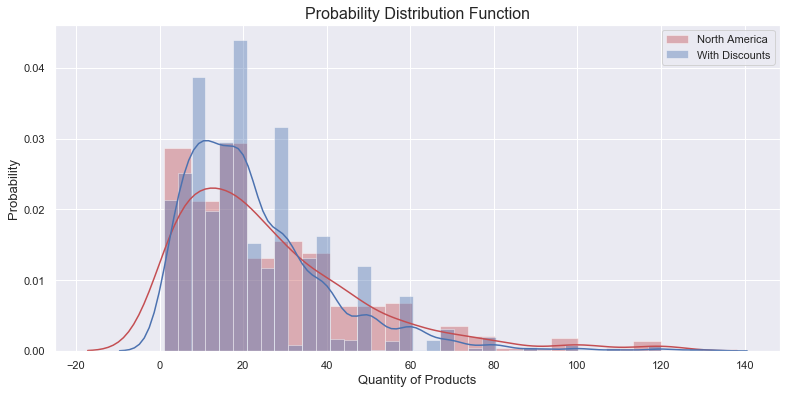

In [101]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(13,6)})

sns.distplot(na_quantity, label = 'North America', color = 'r')
sns.distplot(int_quantity, label = 'With Discounts') 

plt.title('Probability Distribution Function', size = 16)
plt.ylabel('Probability', size = 13)
plt.xlabel('Quantity of Products', size = 13)

plt.legend()
plt.show()

Again, we'll check for normality within the distributions using the shapiro test:

In [90]:
north_america = stats.shapiro(na_quantity)
international = stats.shapiro(int_quantity)

print('The p_value for orders in North America is:', north_america[1])
print('The p_value for international orders is:', international[1])

The p_value for orders in North America is: 4.521583261198347e-19
The p_value for international orders is: 2.4841586909683254e-37


Given the low p_value for the distibutions, we'll need to again apply the Central Limit Theorem to answer this question by taking a sampling of the parent populations and calculating the means from each sample: 

In [91]:
na_quantity_samps = [na_quantity['Quantity'].sample(n=30, replace = True).mean() for i in range (100)]
int_quantity_samps = [int_quantity['Quantity'].sample(n=30, replace = True).mean() for i in range (100)]

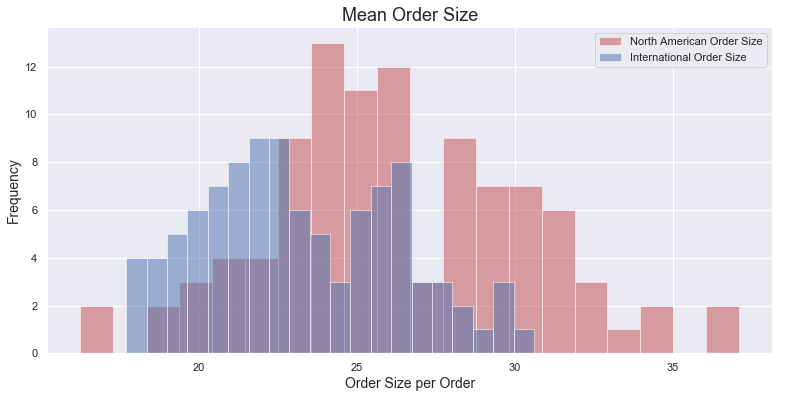

In [93]:
plt.hist(na_quantity_samps, label = 'North American Order Size', alpha = .5, color='r', bins=20)
plt.hist(int_quantity_samps, label = 'International Order Size', alpha = .5, color = 'b', bins=20)

plt.title('Mean Order Size', size = 18)
plt.xlabel('Order Size per Order', size = 14)
plt.ylabel('Frequency', size = 14)

plt.legend()
plt.show()

We'll re-run our shapiro test to confirm normality in the sampling distributions:

In [94]:
north_america = stats.shapiro(na_quantity_samps)
international = stats.shapiro(int_quantity_samps)

print('The p_value for orders in North America is:', north_america[1])
print('The p_value for international orders is:', international[1])

The p_value for orders in North America is: 0.7403030395507812
The p_value for international orders is: 0.054589156061410904


Now that we have normaility in our distributions, let's run our two sample t-test to assess statistically signifant differences between North America and International order sizes:

In [95]:
tstat, pval = scs.ttest_ind(na_quantity_samps, int_quantity_samps)

print('T-Value = ', tstat)
print('P-Value = ', pval)

T-Value =  5.92755021207096
P-Value =  1.3460531162653818e-08


We'll run our Cohen's D function to asses the effect size between domestic and international orders:

In [99]:
north_america = pd.DataFrame(na_quantity_samps)
international = pd.DataFrame(int_quantity_samps)

In [100]:
cohens_d(north_america, international)

The cohen's statistic is: 0    0.838282
dtype: float64


#### *Conclusion:*

With a p_value less than 0.05, we can reject the null hypothesis and accept the alternative hypothesis: Orders in North America appear to be higher than international orders. With a Cohen's D value of 0.84, the effect size of the control group against the treatment group is large.

### *Test Three  - ANOVA*

**Does order size vary in a statistically signficant way between Northwind employees?**

For this test, our treatment group are the employee and the number of products sold per order is our control group.

> - Ho: $\mu_1 = \mu_2 = ... mu_k$ - There is no statistically significant variation in quantity of products per orders sold per employee. 
> - Ha: $\mu_1 \neq \mu_2 \neq... mu_k$  - There is a statistically significant variation in quantity of products per orders sold per employee.

First, we'll write a query that builds a datafame isolating the employee's last name (treatment) and the quantity of products sold per order per employee (treatment): 

In [105]:
employee_orders = pd.read_sql_query(
    '''
    SELECT
    
    e.lastname,
    od.quantity
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN employee AS e
    ON o.employeeid = e.id
    
    ''', engine)

employee_orders.head()

2019-06-14 21:25:47,888 INFO sqlalchemy.engine.base.Engine 
    SELECT
    
    e.lastname,
    od.quantity
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN employee AS e
    ON o.employeeid = e.id
    
    
2019-06-14 21:25:47,889 INFO sqlalchemy.engine.base.Engine ()


,LastName,Quantity
0,Buchanan,12
1,Buchanan,10
2,Buchanan,5
3,Suyama,9
4,Suyama,40


We'll run our ANOVA test to check to statistically significant variations among employee order sizes:

In [125]:
formula = 'Quantity~C(LastName)'
lm = ols(formula, employee_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F   PR(>F)
C(LastName)    4643.183282     8.0  1.607646  0.11745
Residual     774756.452913  2146.0       NaN      NaN


#### *Conclusion:* 

With a PR(>F) value greater than our alpha of .05, we fail to reject the null hypothesis. There is not a statistically significant variation in order size per emloyee.

### *Test Four  - Two Sample T-Test*

**Does the average revenue per order differ in 2014 from 2012 & 2013?**

> For this question, the average revenue per order in 2012 & 2013 is our control group. We'll attempt to find a statistically significant difference in average revenue per order from our treatment group, 2014.
> - Ho: $\mu_1 = \mu_2$ - Control group = Treatment group: The average revenue per order is the same in 2014 & 2012 + 2013.
> - Ha: $\mu_1 \neq \mu_2$ - Control group $\neq$ Treatment group: The average revenue per order is not the same in 2014 & 2012 + 2013


In [107]:
rev_date = pd.read_sql_query(
    '''
    SELECT 
    
    p.unitprice,
    od.quantity,
    od.discount,
    o.orderdate
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN product AS p
    ON p.id = od.productid
    
    ''', engine)

rev_date.head()


2019-06-14 21:27:35,756 INFO sqlalchemy.engine.base.Engine 
    SELECT 
    
    p.unitprice,
    od.quantity,
    od.discount,
    o.orderdate
    
    FROM orderdetail AS od
    JOIN [order] AS o
    ON od.orderid = o.id
    JOIN product AS p
    ON p.id = od.productid
    
    
2019-06-14 21:27:35,757 INFO sqlalchemy.engine.base.Engine ()


,UnitPrice,Quantity,Discount,OrderDate
0,21.00,12,0.0,2012-07-04
1,14.00,10,0.0,2012-07-04
2,34.80,5,0.0,2012-07-04
3,23.25,9,0.0,2012-07-05
4,53.00,40,0.0,2012-07-05


In order to run our statistical test we'll need to isolate the year from the 'OrderDate' column:

In [108]:
yr = rev_date['OrderDate'].str.split('-', n = 1, expand = True)
rev_date['Year'] = yr[0]
rev_date.drop(columns=['OrderDate'], inplace = True)
rev_date.head()

,UnitPrice,Quantity,Discount,Year
0,21.00,12,0.0,2012
1,14.00,10,0.0,2012
2,34.80,5,0.0,2012
3,23.25,9,0.0,2012
4,53.00,40,0.0,2012


Let's check out data types to ensure our newly created year column is an integer:

In [109]:
rev_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
Year         2155 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 67.4+ KB


Because the 'year' column is currently an object dataype, we'll need to recast it as an integer in order to run our statistical test:

In [111]:
rev_date['Year'] = rev_date['Year'].astype(int)
rev_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
Year         2155 non-null int64
dtypes: float64(2), int64(2)
memory usage: 67.4 KB


Next, we'll create a new column called 'Revenue' and calculate the total revenue per order:

In [112]:
rev_date['Revenue'] = rev_date['UnitPrice'] * (1-rev_date['Discount']) * rev_date['Quantity']
rev_date.head()

,UnitPrice,Quantity,Discount,Year,Revenue
0,21.00,12,0.0,2012,252.00
1,14.00,10,0.0,2012,140.00
2,34.80,5,0.0,2012,174.00
3,23.25,9,0.0,2012,209.25
4,53.00,40,0.0,2012,2120.00


Now that we've calculated our revenue per order, let's drop the unnecessary columns and isolate our control and treatment variables:

In [113]:
rev_by_yr = rev_date.drop(columns = ['UnitPrice','Quantity','Discount'], axis = 1)
rev_by_yr.head()

,Year,Revenue
0,2012,252.00
1,2012,140.00
2,2012,174.00
3,2012,209.25
4,2012,2120.00


We'll creat a new dataframe that houses the revenue data per order for 2012 and 2013. We'll drop the 'Year' column as well as that's no longer needed:

In [124]:
years_2012_2013 = rev_by_yr[rev_by_yr['Year'] != 2014]
years_2012_2013.drop(columns = ['Year'], axis = 1, inplace = True)
years_2012_2013.head()

,Revenue
0,252.00
1,140.00
2,174.00
3,209.25
4,2120.00


Let's do the same for 2014 revenue:

In [115]:
year_2014 = rev_by_yr[rev_by_yr['Year'] == 2014]
year_2014.drop(columns = 'Year', inplace = True)
year_2014.head()

,Revenue
1464,646.0
1465,765.0
1466,140.0
1467,42.0
1468,70.0


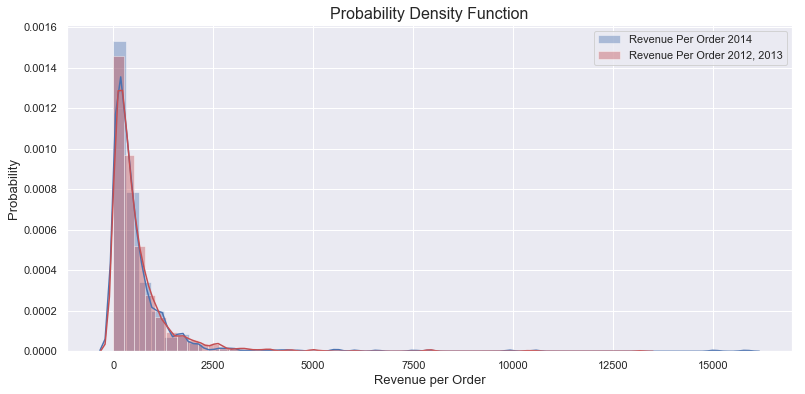

In [116]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(13,6)})

sns.distplot(year_2014, label = 'Revenue Per Order 2014')
sns.distplot(years_2012_2013, label = 'Revenue Per Order 2012, 2013', color = 'r') 

plt.title('Probability Density Function', size = 16)
plt.ylabel('Probability', size = 13)
plt.xlabel('Revenue per Order', size = 13)

plt.legend()
plt.show()

Let's take a look at the same basic statistics for both our control and treatment group: 

In [117]:
print('-'*100)
print('Number of orders for 2014:', len(year_2014))
print('Number of order ofr 2012, 2013:', len(years_2012_2013)) 
#print()
print('-'*100)
#print()
print('Average revenue per order in 2014: {}'.format(year_2014['Revenue'].mean()))
print('Average revenue per order in 2012 & 2013: {}'.format(years_2012_2013['Revenue'].mean()))
print('-'*100)
print('The mean delta: ', abs((year_2014['Revenue'].mean()) - (years_2012_2013['Revenue'].mean())))

----------------------------------------------------------------------------------------------------
Number of orders for 2014: 691
Number of order ofr 2012, 2013: 1464
----------------------------------------------------------------------------------------------------
Average revenue per order in 2014: 637.6611664254702
Average revenue per order in 2012 & 2013: 623.6879094945356
----------------------------------------------------------------------------------------------------
The mean delta:  13.973256930934667


Let's check for distribution normality by running the shapiro test:

In [118]:
year_2014_norm = stats.shapiro(year_2014)
year_2012_2013_norm = stats.shapiro(years_2012_2013)

print('The p_value for orders in 2014 is: ', year_2014_norm[1])
print('The p_value for orders in 2012, 2013:', year_2012_2013_norm[1])

The p_value for orders in 2014 is:  6.375908012677918e-43
The p_value for orders in 2012, 2013: 0.0


The results of our shapiro test indicate non-normal distributions, so we'll again need to solve for this by resampling the control and treatment populations: 

In [127]:
samps_2012_2013 = [years_2012_2013['Revenue'].sample(n=30, replace = True).mean() for i in range (100)]
samps_2014 = [year_2014['Revenue'].sample(n=30, replace = True).mean() for i in range (100)]

In [72]:
plt.hist(samps_2014, label = 'Revenue per Order 2014', alpha = .5, color='r', bins=20)
plt.hist(samps_2012_2013, label = 'Revenue per Order 2012 & 2013', alpha = .5, color='b', bins=20)

plt.title('Revenue', size = 18)
plt.xlabel('Revenue per Order', size = 14)
plt.ylabel('Frequency', size = 14)

plt.legend()
plt.show()

NameError: name 'samps_2014' is not defined

Let's run our t-test and look for a statistically significant difference in average revenue per order between the years 2012 & 2013 and 2014:

In [121]:
tstat, pval = scs.ttest_ind(samps_2012_2013, samps_2014)

print('T-Value = ', tstat)
print('P-Value = ', pval)

T-Value =  -0.9201347208679673
P-Value =  0.358622021760458


Let's run our Cohen's D test to assess the relative effect size in the difference of mean revenue per order from 2012 & 2013, and 2014:

In [122]:
samps_2014 = pd.DataFrame(samps_2014)
samps_2012_2013 = pd.DataFrame(samps_2012_2013)

In [123]:
cohens_d(samps_2014, samps_2012_2013)

The cohen's statistic is: 0    0.130127
dtype: float64


#### *Conclusion:* 

With a p_value greater than .05, we fail to reject the null hypothesis: the average revenue per order in 2014 is not statistically different than in 2012 & 2013. 

------------------------------------------------------------------------------------------------------------------

## Conclusion <a id='conclusion'></a>

[Back to top](#top)

The following is a summation of our findings :

**Test One (Discounts):** 
- Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

**Conclusion One:**
- *Part One*: Yes, discounts do have a significant impact on the number of products ordered. Not only do they increase the number of products ordered, but we can say the impact of applying discounts is significant.

- *Part Two*: Generally, discounts have significantly impact the number of products ordered at most levels with the exception of discounts at the 10% level. 

------------------------------------------------------------------------------------------------------------------

**Test Two (Efficiency)**:
- Is the average order size in North America larger than international order sizes?

**Conclusion Two:**
- Order sizes in North America are indeed higher on average than international order sizes. The impact on order size between domestic and foreign shipping is significant.

------------------------------------------------------------------------------------------------------------------

**Test Three (Employees)**:
- Does order size vary in a statistically significant way between Northwind employees?

**Conclusion Three:**
-  There seems to be no statistically significant variation in the average size per order between Northwind employees.

------------------------------------------------------------------------------------------------------------------

**Test Four (Revenue)**:
- Does the average revenue per order differ in 2014 from 2012 & 2013?

**Conclusion Four:**
- The average revenue per order does not vary from 2014 to 2012 & 2013. In fact, it appears revenue per order decreases slightly from 2014 to 2012 & 2013. However, we cannot accept this conclusion with confidence. 

------------------------------------------------------------------------------------------------------------------

## Future Work <a id='futurework'></a>

[Back to top](#top)

There is much to be done to continue drawing insights from our data. Below we provide recommendations for future work to further advance :

**Discounts**:
>Use them to push inventory, but further work is needed to asses the impact of discounts on revenue. Although discounts lead to higher inventory turnover, we don't yet have an understanding of their impact on revenue. Additional tests are needed to assess whether or not discounts impact revenue, and if so, to test and quantify the impact of discounts on revenue.


**Efficiency:**
> If the goal is to increase revenue per order, and thus efficiency, we must better understand why order sizes in North America are larger on average than international orders. Does shipping costs impact order size? Are international customers operating under different storage constraints than domestic customers? Do international customers submit more orders on average than domestic? We must investigate these factors and apply resources towards increasing the order size of the international customers. 

**Employees:**
> We concluded there is no variation in order size per employee. That said, further research is needed to suss out employees that perform better by other metric means. Perhaps the number of orders vary significantly between employees? And if so, how do we extract techniques from higher performing employees and apply those to lower performing employees? Further, we might look at the cost per order based on the employees salary. If order size, and thus efficiency, does not vary between employees, then what about the costs per order associated with each employee and their respective salary? 

**Revenue:**
> Revenue per order does not increase between 2012 & 2013 to 2014, which is not ideal from the standpoint of cost reduction. Northwind's goal should center on increasing revenue per order. We must further investigate factors that influence revenue per order and apply the necessary resources to improve the established KPIs around efficiency. 